This is not actually asked in the assignment, but done just to check how grey scale image patches reconstruct when we use matrix factorization. 

This file also serves as an example as to how integer values(0 to 255) of image matrix reconstruct.

Just done to check, if there is anything different which happens wrt to matrix factorization

Can be ignored for grading 

The same for coloured images which is actually required is done properly in a different ipynb file.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
print(device)

# Retina display
%config InlineBackend.figure_format = 'retina'

mps


In [2]:
!wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

--2024-09-20 16:38:39--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 99.84.203.93, 99.84.203.80, 99.84.203.111, ...
Connecting to segment-anything.com (segment-anything.com)|99.84.203.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K   301KB/s    in 0.7s    

2024-09-20 16:38:41 (301 KB/s) - ‘dog.jpg’ saved [221810/221810]



In [3]:
# Read in a image from torchvision
import torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


In [4]:
# Make grayscale
img = torch.tensor(img, dtype=torch.float)
img = img.mean(dim=0, keepdim=False)
print(img.shape)

torch.Size([1365, 2048])


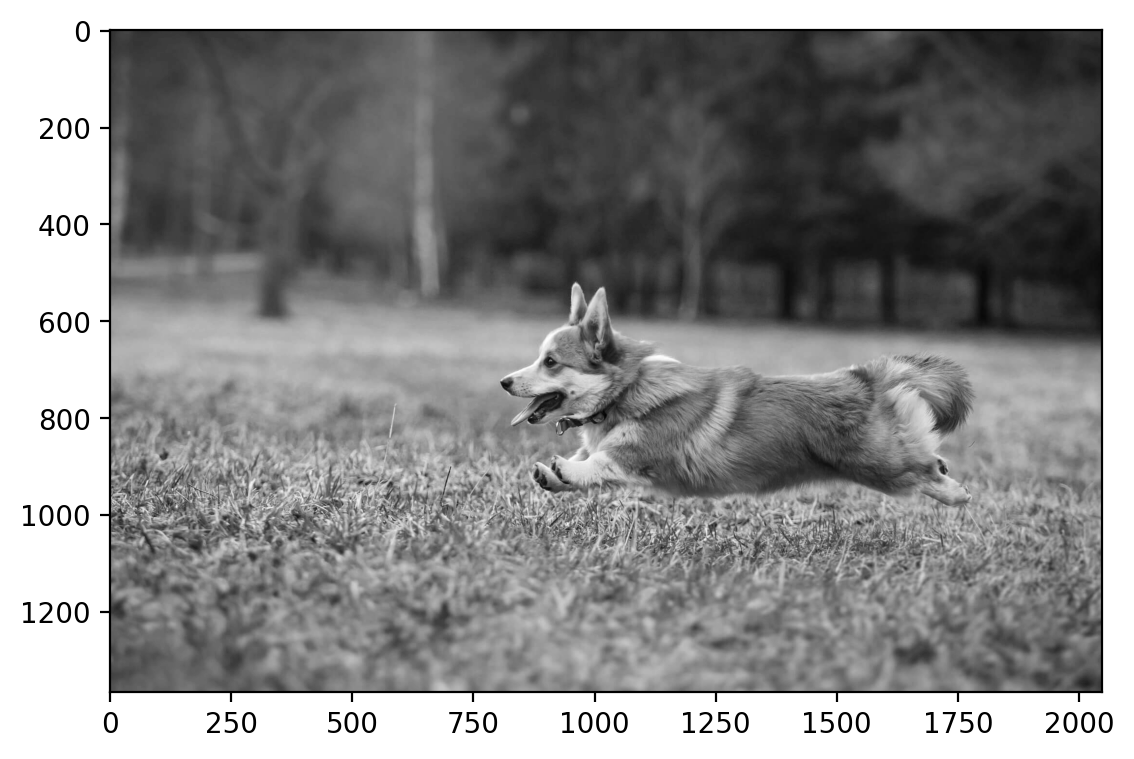

In [5]:
plt.imshow(img, cmap='gray')

In [6]:
crop = torchvision.transforms.functional.crop(img, 600, 800, 300, 300)
crop.shape

torch.Size([300, 300])

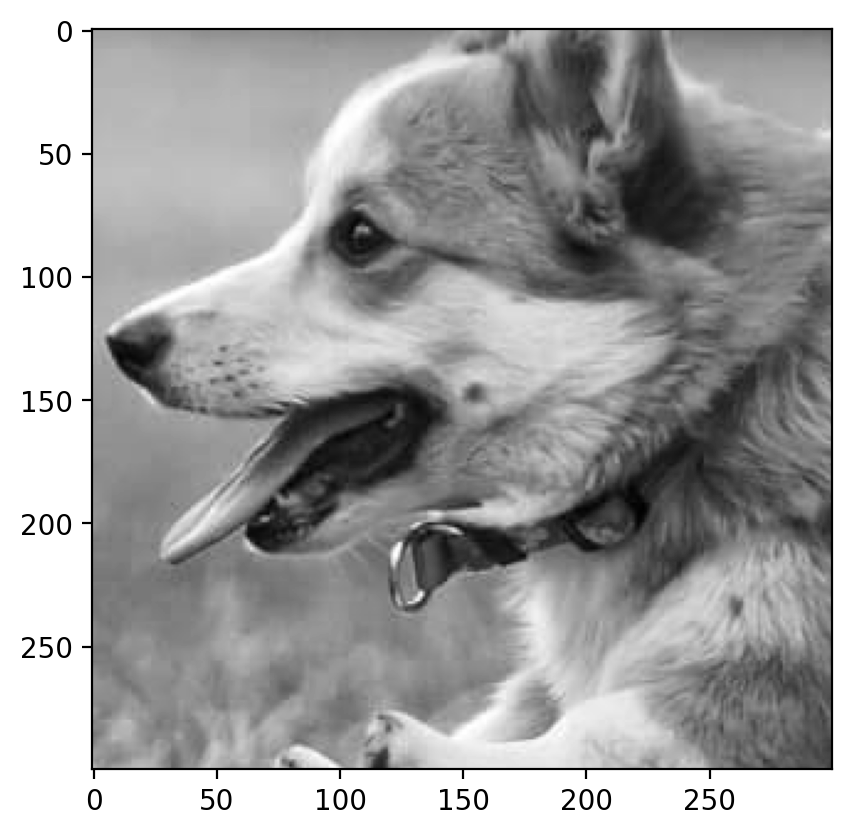

In [7]:
plt.imshow(crop, cmap='gray')

torch.Size([50, 50])
torch.Size([50, 50])


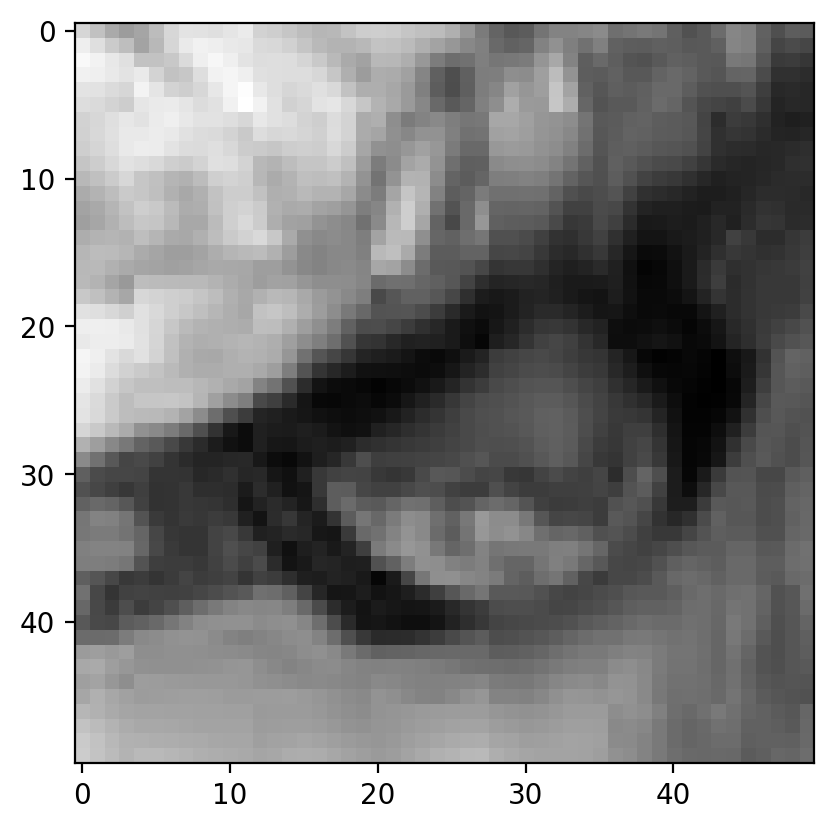

In [8]:
patch1, patch2 = torchvision.transforms.functional.crop(crop, 60, 80, 50, 50), torchvision.transforms.functional.crop(crop, 100, 0, 50, 50)
patch3 = torchvision.transforms.functional.crop(crop, 170, 180, 50, 50)
print(patch1.shape)
print(patch2.shape)
plt.imshow(patch3, cmap='gray')

In [9]:
# Modify the loss function to ignore NaN values
def factorize(A, k, device=torch.device("cpu")):
    """Factorize the matrix D into A and B"""
    A = A.to(device)
    # Randomly initialize A and B
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    # Train the model
    for i in range(1000):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
    return W, H, loss

In [10]:
from sklearn.metrics import mean_squared_error

def plot(original_image, k_values=[5, 10, 25, 50], device='cpu'):
    fig, axs = plt.subplots(1, 1 + len(k_values), figsize=(20, 5.5))
    original_image = original_image.to(device)
    original_img_np = original_image.cpu().detach().numpy()
    axs[0].imshow(original_img_np, cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    for i, k in enumerate(k_values):
        W, H, loss = factorize(original_image, k, device=device)
        reconstructed_img = torch.mm(W, H)
        rmse = np.sqrt(mean_squared_error(original_image.cpu().detach().numpy(), reconstructed_img.cpu().detach().numpy()))
        psnr = 20 * np.log10(255 / rmse)
        if rmse == 0:
            psnr = float('inf')              
        reconstructed_img_np = reconstructed_img.cpu().detach().numpy()
        axs[i + 1].imshow(reconstructed_img_np, cmap='gray')
        axs[i + 1].set_title(f'r={k}, Loss={loss.item():.4f}, RMSE={rmse:.4f}, \n PSNR={psnr:.4f} dB')
        axs[i + 1].axis('off')

    plt.suptitle('Original and Reconstructed Images for Different rank(r) Values')
    plt.tight_layout()
    plt.show()

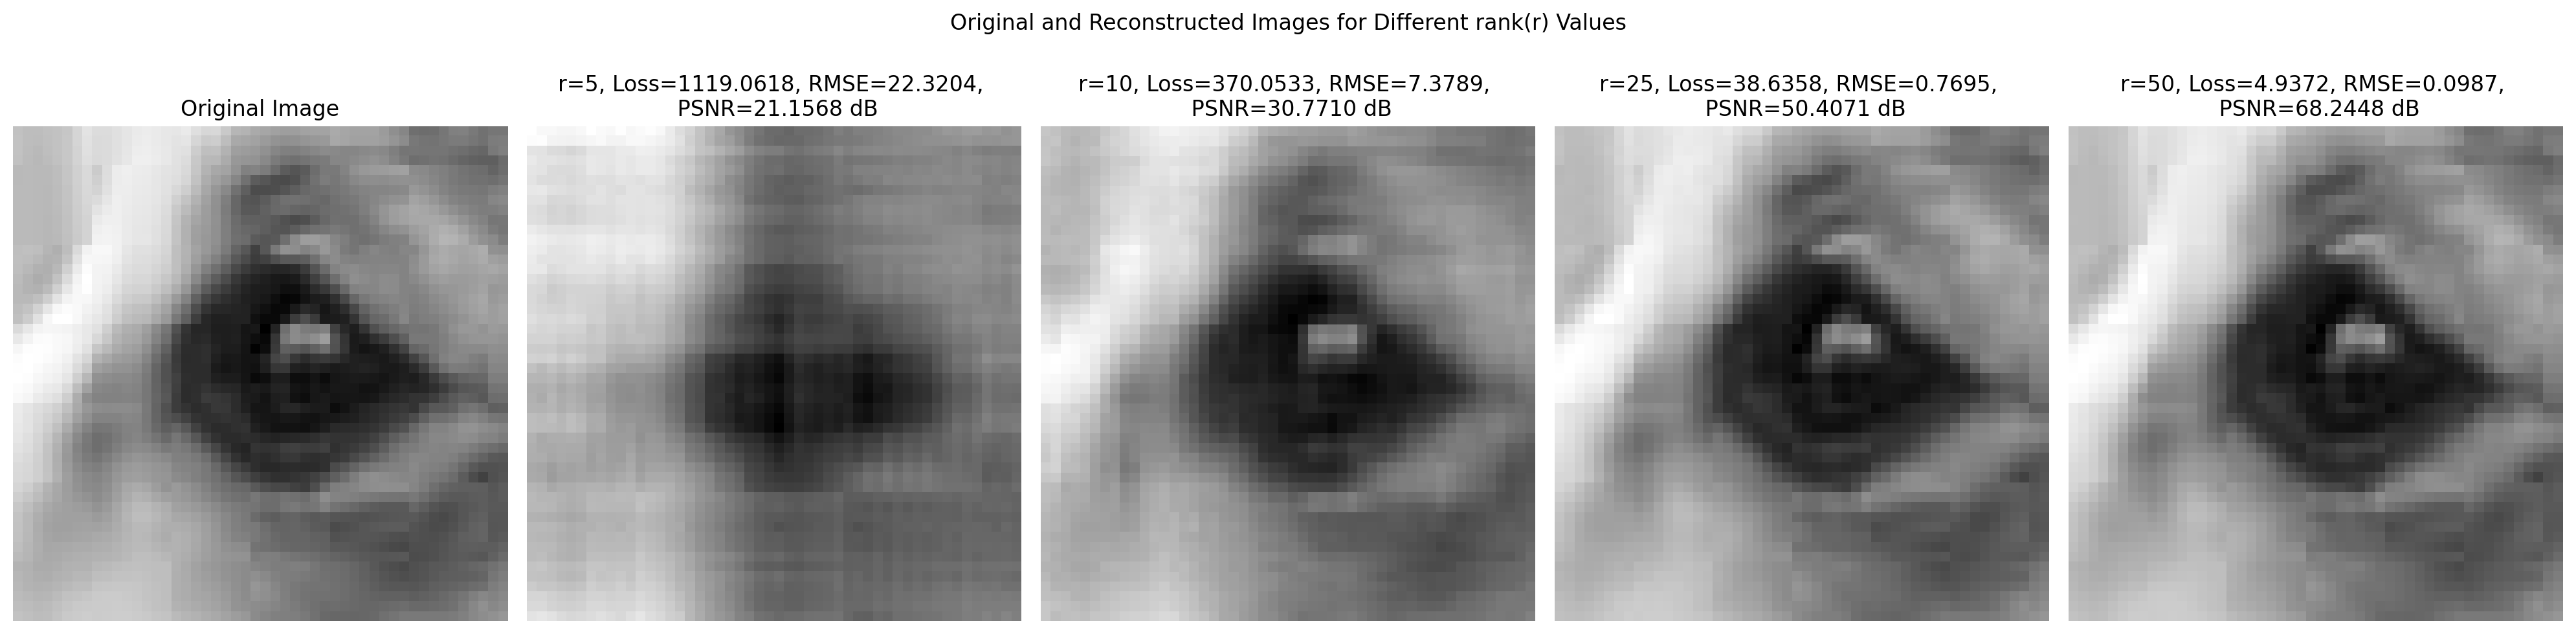

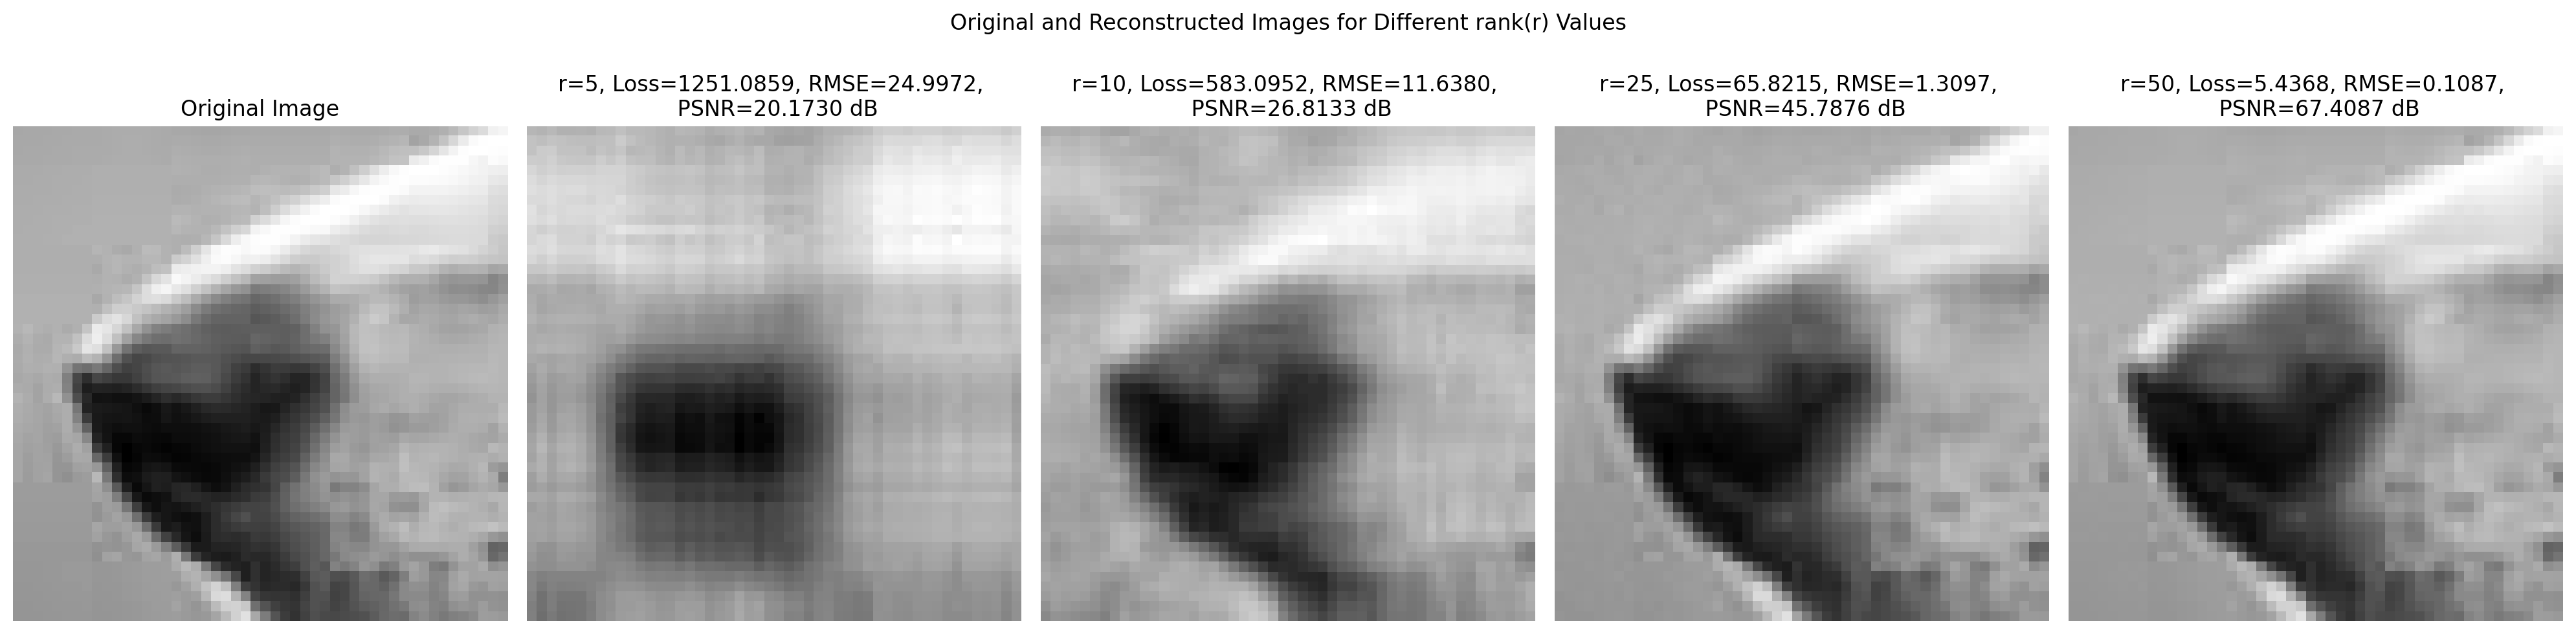

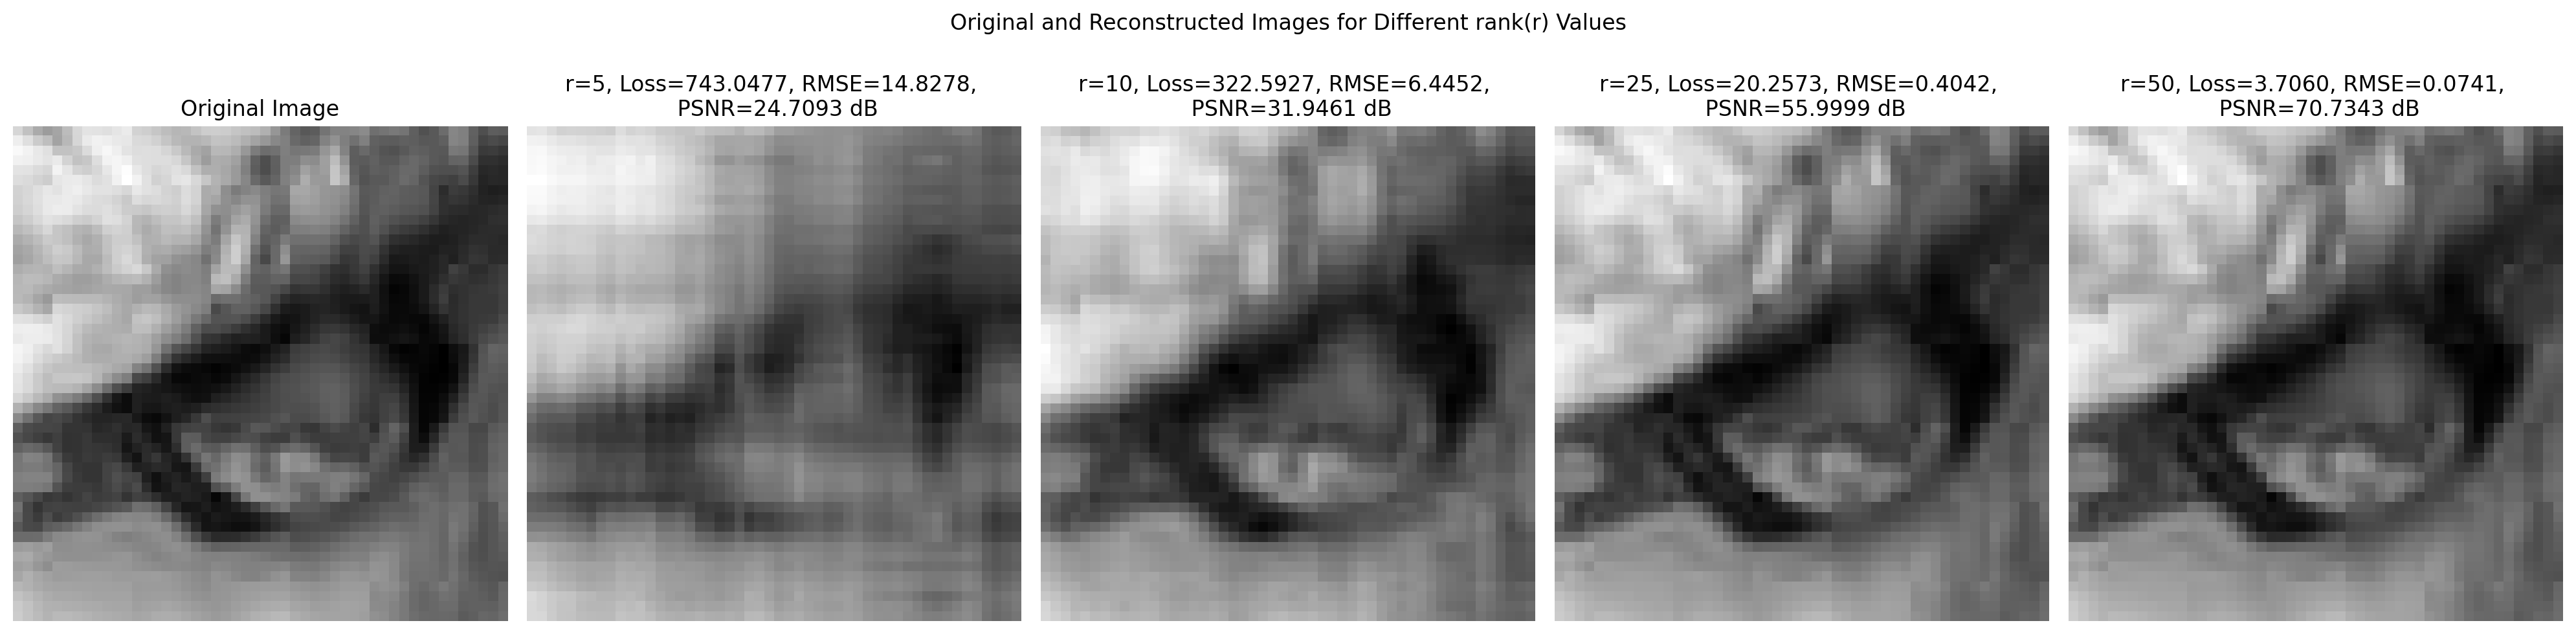

In [11]:
plot(patch1)
plot(patch2)
plot(patch3)